In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
import joblib
import cv2
from google.colab import drive

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/'
dataset_path = os.path.join(root_dir,'Steganography/Dataset')

train_csv = os.path.join(root_dir,'train_dataset.csv')
test_csv = os.path.join(root_dir,'Steganography/validation_dataset.csv')
train_folder = os.path.join(dataset_path,'train')
validation_folder = os.path.join(dataset_path,'Valid')

In [4]:
cover = '/content/drive/MyDrive/Colab Notebooks/Steganography/Lion.jpg'
secret = '/content/drive/MyDrive/Colab Notebooks/Steganography/Tiger.jpg'

dataset = [{
        'cover_image':cover,
        'secret_image':secret
    }]
dataframe = pd.DataFrame(dataset)
cover = Image.open(cover)
secret = Image.open(secret)


In [5]:
%matplotlib inline

In [6]:

IMG_SIZE = 64
LEARNING_RATE  = 0.001
COVER_LOSS_WEIGHT = 1
SECRET_LOSS_WEIGHT = 1
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 1
EPOCHS = 1000
DECODER_LOSS_WEIGHT = 1

In [7]:
imagetransformation = {
    'train_transforms':torchvision.transforms.Compose([torchvision.transforms.Resize((IMG_SIZE,IMG_SIZE)),torchvision.transforms.ToTensor()]),
    'valid_transforms':torchvision.transforms.Compose([torchvision.transforms.Resize((IMG_SIZE,IMG_SIZE)),torchvision.transforms.ToTensor()]),
    'test_transforms':torchvision.transforms.Compose([torchvision.transforms.Resize(cover.size),torchvision.transforms.ToTensor()])
}

In [8]:
#conversion of image into resized format and return of trnasformed image
class SteganoDataset(torch.utils.data.Dataset):
    def __init__(self,dataset_csv,transforms,type_of_dataset,size='complete'):
        #self.dataset = pd.read_csv(dataset_csv)
        self.dataset = dataset_csv
        self.dataset = self.dataset.reset_index(drop=True)
        if size !='complete':
            self.dataset = self.dataset[:2]
        self.transforms = transforms
        self.type = type_of_dataset
    
    def __getitem__(self,index):
        cover_image = self.dataset.iloc[index]['cover_image']
        secret_image = self.dataset.iloc[index]['secret_image']
        cover_image = Image.open(os.path.join(dataset_path,'train',cover_image))
        secret_image = Image.open(os.path.join(dataset_path,'train',secret_image))
        transformed_cover_image = self.transforms(cover_image)
        transformed_secret_image = self.transforms(secret_image)
        return {
                'cover_image':transformed_cover_image,
                'secret_image':transformed_secret_image,
            }
        
    
    def __len__(self):
      return len(self.dataset)

In [9]:
class PrepNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=20,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=35,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=35,out_channels=20,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=35,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
    
    def forward(self,secret_image):
        output_1 = F.relu(self.conv1(secret_image))
        output_2 = F.relu(self.conv2(secret_image))
        output_3 = F.relu(self.conv3(secret_image))
        
        concatenated_image = torch.cat([output_1,output_2,output_3],dim=1)
        output_4 = F.relu(self.conv4(concatenated_image))
        output_5 = F.relu(self.conv5(concatenated_image))
        output_6 = F.relu(self.conv6(concatenated_image))
        
        final_concat_image = torch.cat([output_4,output_5,output_6],dim=1)
        return final_concat_image

class HidingNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=38,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=38,out_channels=20,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=38,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=35,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=35,out_channels=20,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=35,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv7 = nn.Conv2d(in_channels=35,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv8 = nn.Conv2d(in_channels=35,out_channels=20,kernel_size=(3,3),stride=1,padding=1)
        self.conv9 = nn.Conv2d(in_channels=35,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.final_layer = nn.Conv2d(in_channels=35,out_channels=3,kernel_size=(3,3),stride=1,padding=1)
        
    def forward(self,secret_image,cover_image):
        concatenated_secrets = torch.cat([cover_image,secret_image],dim=1)
        
        output_1 = F.relu(self.conv1(concatenated_secrets))
        output_2 = F.relu(self.conv2(concatenated_secrets))
        output_3 = F.relu(self.conv3(concatenated_secrets))
        concat_1 = torch.cat([output_1,output_2,output_3],dim=1)
        
        output_4 = F.relu(self.conv4(concat_1))
        output_5 = F.relu(self.conv5(concat_1))
        output_6 = F.relu(self.conv6(concat_1))
        concat_2 = torch.cat([output_4,output_5,output_6],dim=1)
        
        output_7 = F.relu(self.conv7(concat_2))
        output_8 = F.relu(self.conv8(concat_2))
        output_9 = F.relu(self.conv9(concat_2))
        concat_3 = torch.cat([output_7,output_8,output_9],dim=1)
        output_converted_image = F.relu(self.final_layer(concat_3))
        
        return output_converted_image

In [10]:
class Encoder(nn.Module):
    def __init__(self,prep_network,hiding_network):
        super().__init__()
        self.prep_network = prep_network
        self.hiding_network = hiding_network
    
    def forward(self,cover_image,secret_image):
        encoded_secret_image = self.prep_network(secret_image)
        
        hidden_image = self.hiding_network(encoded_secret_image,
                                           cover_image
                                          )
#         hidden_image = (0.01**0.5)*torch.randn(hidden_image.size(),device=device)
        return hidden_image

In [11]:
class RevealNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=20,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=35,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=35,out_channels=20,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=35,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv7 = nn.Conv2d(in_channels=35,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv8 = nn.Conv2d(in_channels=35,out_channels=20,kernel_size=(3,3),stride=1,padding=1)
        self.conv9 = nn.Conv2d(in_channels=35,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        
        self.final_layer = nn.Conv2d(in_channels=35,out_channels=3,kernel_size=(3,3),stride=1,padding=1)    
    
    def forward(self,hidden_image):
        
        output_1 = F.relu(self.conv1(hidden_image))
        output_2 = F.relu(self.conv2(hidden_image))
        output_3 = F.relu(self.conv3(hidden_image))
        concat_1 = torch.cat([output_1,output_2,output_3],dim=1)
        
        output_4 = F.relu(self.conv4(concat_1))
        output_5 = F.relu(self.conv5(concat_1))
        output_6 = F.relu(self.conv6(concat_1))
        concat_2 = torch.cat([output_4,output_5,output_6],dim=1)
        
        output_7 = F.relu(self.conv7(concat_2))
        output_8 = F.relu(self.conv8(concat_2))
        output_9 = F.relu(self.conv9(concat_2))
        concat_3 = torch.cat([output_7,output_8,output_9],dim=1)
        
        
        output_revealed_image = F.relu(self.final_layer(concat_3))
        
        return output_revealed_image

In [12]:
class Decoder(nn.Module):
    def __init__(self,reveal_network):
        super().__init__()
        self.reveal_network = reveal_network
    
    def forward(self,hidden_image):
        reveal_image = self.reveal_network(hidden_image)
        return reveal_image

In [13]:
class SteganoModel(nn.Module):
    def __init__(self,encoder,decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self,cover_image,secret_image,hidden_image,mode):
        if mode == 'full':
            for param in self.encoder.parameters():
                param.requires_grad = True
            for param in self.decoder.parameters():
                param.requires_grad = False
            hidden_image = self.encoder(cover_image,secret_image)
            reveal_image = self.decoder(hidden_image)
            return hidden_image,reveal_image
        elif mode == 'encoder':
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False
            hidden_image = self.encoder(cover_image,secret_image)
            return hidden_image
        elif mode == 'decoder':
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = True
            
            reveal_image = self.decoder(hidden_image)
            return reveal_image

In [ ]:

# filename = os.path.join("/content/drive/MyDrive/Colab_Notebooks/Steganography/Completed_model2.joblib")
# # loaded_model = joblib.load(filename)
# joblib.dump(model, filename)

In [14]:
prep_net = PrepNetwork()
hiding_network = HidingNetwork()

encoder = Encoder(prep_net,hiding_network)

reveal_net = RevealNetwork()


decoder = Decoder(reveal_net)

model = SteganoModel(encoder,decoder)
model.to(device)

SteganoModel(
  (encoder): Encoder(
    (prep_network): PrepNetwork(
      (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv4): Conv2d(35, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv5): Conv2d(35, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv6): Conv2d(35, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (hiding_network): HidingNetwork(
      (conv1): Conv2d(38, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(38, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(38, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv4): Conv2d(35, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv5): Conv2d(35, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [15]:
class SteganoLoss(nn.Module):
    def __init__(self,cover_weight,secret_weight):
        super().__init__()
        self.cover_weight = cover_weight
        self.secret_weight = secret_weight
        
    def forward(self,predicted_cover_image,cover_image,
               predicted_secret_image_1,secret_image_1):
    
        cover_loss = self.cover_weight*(F.mse_loss(predicted_cover_image,cover_image))
        secret_loss = self.secret_weight*(F.mse_loss(predicted_secret_image_1,secret_image_1)) 
        return cover_loss + secret_loss

class DecoderLoss(nn.Module):
    def __init__(self,decoder_loss_weight):
        super().__init__()
        self.decoder_loss_weight = decoder_loss_weight
    
    def forward(self,reveal_output,secret_image):
        reveal = self.decoder_loss_weight*F.mse_loss(reveal_output,secret_image)
        return reveal

In [ ]:

training_csv_path = os.path.join(dataset_path,train_csv)
test_csv_path = os.path.join(dataset_path,test_csv)

training_dataset = SteganoDataset(training_csv_path,imagetransformation['train_transforms'],'train','complete')
test_dataset = SteganoDataset(training_csv_path,imagetransformation['train_transforms'],'Train','complete')


AttributeError: ignored

In [16]:
test_dataset = SteganoDataset(dataframe,imagetransformation['test_transforms'],'Valid')


# train_data_loader = torch.utils.data.DataLoader(training_dataset, 
#                                                 batch_size = TRAIN_BATCH_SIZE, 
#                                                 shuffle=True,
#                                                drop_last = True,
#                                                num_workers = 0
#                                                )
# valid_data_loader = torch.utils.data.DataLoader(valid_dataset, 
#                                                 batch_size = VALID_BATCH_SIZE, 
#                                                 shuffle=True,
#                                                 drop_last = True,
#                                                 num_workers = 0
#                                                )
                                               
test_data_loader = torch.utils.data.DataLoader(test_dataset, 
                                                batch_size = VALID_BATCH_SIZE, 
                                                shuffle=True,
                                                drop_last = True,
                                                num_workers = 0
                                               )



In [ ]:

full_model_criterion = SteganoLoss(SECRET_LOSS_WEIGHT,COVER_LOSS_WEIGHT)

full_model_optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

decoder_criterion = DecoderLoss(DECODER_LOSS_WEIGHT)
training_full_model_loss_list = []
decoder_loss_list = []


In [17]:

def train(model,epochs,decoder_criterion,full_model_optimizer,full_model_criterion,learning_rate,training_iterator):
    print_every=1
    for epoch in range(epochs):
        for index,training_dict in enumerate(training_iterator):

            cover_image = training_dict['cover_image']
            cover_image = cover_image.to(device)

            secret_image = training_dict['secret_image']
            secret_image = secret_image.to(device)

            
            full_model_optimizer.zero_grad()

            encoder_output = model(cover_image,secret_image,secret_image,'encoder')

            hidden_image,reveal_image = model(cover_image,secret_image,secret_image,
                                                                'full')

            full_model_loss = full_model_criterion(hidden_image,cover_image,
                             reveal_image,secret_image
                            )
            full_model_loss.backward()
            full_model_optimizer.step()

            full_model_optimizer.zero_grad()
            reveal_output = model(cover_image,secret_image,
                                                                 encoder_output,'decoder')
            decoder_loss = decoder_criterion(reveal_output,secret_image)

            decoder_loss.backward()
            full_model_optimizer.step()

        training_full_model_loss_list.append(full_model_loss)
        decoder_loss_list.append(decoder_loss)
        if epoch % print_every == 0:
            print("Training full model loss at {} epochs is: {}".format(epoch, full_model_loss))
            print("Training decoder loss at {} epochs is: {}".format(epoch, decoder_loss))

    return model, training_full_model_loss_list,decoder_loss_list


Training full model loss at 0 epochs is: 0.14862200617790222
Training decoder loss at 0 epochs is: 0.056159209460020065
Training full model loss at 50 epochs is: 0.010316253639757633
Training decoder loss at 50 epochs is: 0.006905762478709221
Training full model loss at 100 epochs is: 0.005915718153119087
Training decoder loss at 100 epochs is: 0.004135390743613243
Training full model loss at 150 epochs is: 0.00597141869366169
Training decoder loss at 150 epochs is: 0.003256219904869795
Training full model loss at 200 epochs is: 0.004562869668006897
Training decoder loss at 200 epochs is: 0.0032390698324888945
Training full model loss at 250 epochs is: 0.004033954814076424
Training decoder loss at 250 epochs is: 0.00324784847907722
Training full model loss at 300 epochs is: 0.0028372027445584536
Training decoder loss at 300 epochs is: 0.002142705488950014
Training full model loss at 350 epochs is: 0.003511040238663554
Training decoder loss at 350 epochs is: 0.0028315880335867405
Training full model loss at 400 epochs is: 0.006889783777296543
Training decoder loss at 400 epochs is: 0.006818610243499279
Training full model loss at 450 epochs is: 0.0030810432508587837
Training decoder loss at 450 epochs is: 0.0027422530110925436
Training full model loss at 500 epochs is: 0.0026186055038124323
Training decoder loss at 500 epochs is: 0.00222468632273376
Training full model loss at 550 epochs is: 0.0022935508750379086
Training decoder loss at 550 epochs is: 0.0016986110713332891
Training full model loss at 600 epochs is: 0.0017199815483763814
Training decoder loss at 600 epochs is: 0.0012137810699641705
Training full model loss at 650 epochs is: 0.002981864381581545
Training decoder loss at 650 epochs is: 0.002139737131074071
Training full model loss at 700 epochs is: 0.00157183688133955
Training decoder loss at 700 epochs is: 0.0011825517285615206
Training full model loss at 750 epochs is: 0.001144192647188902
Training decoder loss at 750 epochs is: 0.0006921886233612895
Training full model loss at 800 epochs is: 0.0016071755671873689
Training decoder loss at 800 epochs is: 0.0011148437624797225
Training full model loss at 850 epochs is: 0.0016389719676226377
Training decoder loss at 850 epochs is: 0.0010738647542893887
Training full model loss at 900 epochs is: 0.0011910195462405682
Training decoder loss at 900 epochs is: 0.0007727841730229557
Training full model loss at 950 epochs is: 0.0011191064259037375
Training decoder loss at 950 epochs is: 0.0007212755153886974

In [ ]:
model, training_full_model_loss_list, decoder_loss_list = train(model, EPOCHS,decoder_criterion, full_model_optimizer, full_model_criterion, LEARNING_RATE, train_data_loader)

In [ ]:
filename = os.path.join("/content/drive/MyDrive/Colab Notebooks/Steganography/stegomodeltest.pt")
# loaded_model = joblib.load(filename)
torch.save(model,filename)

In [18]:
test = torch.load('/content/drive/MyDrive/Colab Notebooks/Steganography/stegomodeltest.pt')

In [19]:
def predict(model,iterator,mode):


    predict_dict = next(iter(iterator))

    cover_image = predict_dict['cover_image']
    
    cover_image = cover_image.to(device)

    secret_image_1 = predict_dict['secret_image']
    
    secret_image_1 = secret_image_1.to(device)
    

    model.eval()
    if mode=="full":
      hidden_image,reveal_image_1= model(cover_image,secret_image_1,secret_image_1,mode)
      hidden_image[hidden_image>1] = 1
      cover_image = cover_image * 255
      secret_image_1 = secret_image_1 * 255
      hidden_image = hidden_image * 255
      secret_image_1 = secret_image_1.to(torch.device('cpu'))
      cover_image = cover_image.to(torch.device('cpu'))
      hidden_image = hidden_image.to(torch.device('cpu'))
      secret_image_1 = secret_image_1.detach().to(torch.long)
      cover_image = cover_image.detach().to(torch.long)
      hidden_image = hidden_image.detach().to(torch.long)
      h = hidden_image[0].permute(1,2,0).numpy()
      im = Image.fromarray(h.astype(np.uint8))
      im.save("/content/drive/MyDrive/Colab Notebooks/stego_img.png")
    elif mode =='decoder':
      reveal_image_1= model(cover_image,cover_image,cover_image,mode)
    reveal_image_1[reveal_image_1>1] = 1
    reveal_image_1 = reveal_image_1 * 255
    reveal_image_1 = reveal_image_1.to(torch.device('cpu'))
    reveal_image_1 = reveal_image_1.detach().to(torch.long)

    r = reveal_image_1[0].permute(1,2,0).numpy()
    
    im = Image.fromarray(r.astype(np.uint8))
    im.save("/content/drive/MyDrive/Colab Notebooks/revealed.png")
    
    return {
        'cover_image_grid':cover_image[0].permute(1,2,0).numpy(),
        'secret_image_1_grid':secret_image_1[0].permute(1,2,0).numpy(),
        'hidden_image_grid':h,
        'reveal_image_1_grid':r,
    }

In [20]:
def predict(model,iterator,mode):


    predict_dict = next(iter(iterator))

    cover_image = predict_dict['cover_image']
    
    cover_image = cover_image.to(device)

    secret_image_1 = predict_dict['secret_image']
    
    secret_image_1 = secret_image_1.to(device)
    

    model.eval()
    if mode=="full":
      hidden_image,reveal_image_1= model(cover_image,secret_image_1,secret_image_1,mode)
      hidden_image[hidden_image>1] = 1
      cover_image = cover_image * 255
      secret_image_1 = secret_image_1 * 255
      hidden_image = hidden_image * 255
      secret_image_1 = secret_image_1.to(torch.device('cpu'))
      cover_image = cover_image.to(torch.device('cpu'))
      hidden_image = hidden_image.to(torch.device('cpu'))
      secret_image_1 = secret_image_1.detach().to(torch.long)
      cover_image = cover_image.detach().to(torch.long)
      hidden_image = hidden_image.detach().to(torch.long)
      h = hidden_image[0].permute(1,2,0).numpy()
      im = Image.fromarray(h.astype(np.uint8))
      im.save("/content/drive/MyDrive/Colab Notebooks/stego_img.png")
    elif mode =='decoder':
      reveal_image_1= model(cover_image,cover_image,cover_image,mode)
    reveal_image_1[reveal_image_1>1] = 1
    reveal_image_1 = reveal_image_1 * 255
    reveal_image_1 = reveal_image_1.to(torch.device('cpu'))
    reveal_image_1 = reveal_image_1.detach().to(torch.long)

    r = reveal_image_1[0].permute(1,2,0).numpy()
    
    im = Image.fromarray(r.astype(np.uint8))
    im.save("/content/drive/MyDrive/Colab Notebooks/revealed.png")
    
    return {
        'cover_image_grid':cover_image[0].permute(1,2,0).numpy(),
        'secret_image_1_grid':secret_image_1[0].permute(1,2,0).numpy(),
        'hidden_image_grid':h,
        'reveal_image_1_grid':r,
    }

In [21]:
grids = predict(test,test_data_loader,'full')

In [ ]:
from torchvision.utils import save_image


In [23]:
def plot(grids):
    plt.figure(figsize=(15,8))
    
    plt.subplot(241)
    plt.title('Cover Image')
    plt.imshow(grids['cover_image_grid'])

    plt.subplot(242)
    plt.title('Secret Image')
    plt.imshow(grids['secret_image_1_grid'])

    plt.subplot(245)
    plt.title('Hidden Image')
    plt.imshow(grids['hidden_image_grid'])
    
    plt.subplot(246)
    plt.title('Reveal Image')
    plt.imshow(grids['reveal_image_1_grid'])

    plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plot.png')
    plt.show()
    

In [ ]:
'''
data = next(iter(test_data_loader))

cover_image = data['cover_image']
cover_image = cover_image.to(device)

secret_image_1 = data['secret_image']
secret_image_1 = secret_image_1.to(device)

model.eval()
    
hidden_image,reveal_image_1 = model(cover_image,secret_image_1,secret_image_1,'full')
'''

In [ ]:
#make_dot(hidden_image).render('hidden_image',format='png')

In [ ]:
#make_dot(reveal_image_1).render('reveal_image',format='png')

In [ ]:

def plot_loss(loss_list,num):
    plt.plot(torch.tensor(loss_list, device = 'cpu'))
    if(num==1):
      plt.savefig('/content/drive/MyDrive/Colab Notebooks/fullmodeloss.png')
      plt.show()
    else:
      plt.savefig('/content/drive/MyDrive/Colab Notebooks/decoderloss.png')
      plt.show()


In [ ]:
plot_loss(training_full_model_loss_list,1)

In [ ]:
plot_loss(decoder_loss_list,2)

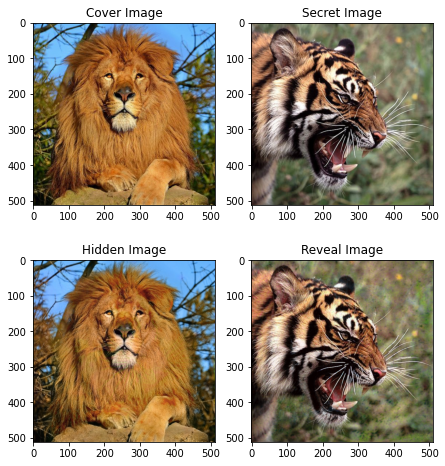

In [24]:
plot(grids)

In [ ]:

for i in range(5):
    grids = predict(test,test_data_loader,'full')
    plot(grids)


In [ ]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import pywt
plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams.update({'font.size': 18})

A = imread('/content/drive/MyDrive/Colab Notebooks/stego_img.png')
print(type(A))
B = np.mean(A, -1); # Convert RGB to grayscale

n = 1
w = 'db1'
coeff = [[],[]]
arr = [[],[],[]]
coeff_slices = [[],[],[]]
for ch in range(3):
  coeffs = pywt.swt2(A[:,:,ch],wavelet=w,level=n)
  # data = np.zeros_like(A)
  # print(data.shape)
  # print(coeffs[0])
  # coeffs[1] = pywt.wavedec2(A[:,:,1],wavelet=w,level=n)
  # coeffs[2] = pywt.wavedec2(A[:,:,2],wavelet=w,level=n)

  # normalize each coefficient array
  
  coeff[0] = coeffs[0][0] / np.abs(coeffs[0][0]).max()
  for detail_level in range(n):
      coeff[detail_level + 1] = [d/np.abs(d).max() for d in coeffs[0][detail_level + 1]]

  arr[ch], coeff_slices[ch] = np.array(pywt.coeffs_to_array(coeff))

final_img = np.dstack([arr[0]*255, arr[1]*255, arr[2]*255]).astype(np.uint8)
print(final_img.shape)

# a = arr[coeff_slices[1]['dd']]
plt.imshow(final_img,cmap='gray',vmin=-0.25,vmax=0.75)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plotwave4.png')
plt.show()

In [ ]:

r_np = imread('/content/drive/MyDrive/Colab Notebooks/Plotwave2.png')
g_np = imread('/content/drive/MyDrive/Colab Notebooks/Plotwave3.png')
b_np = imread('/content/drive/MyDrive/Colab Notebooks/Plotwave4.png')


# Add the channels to the final image
final_img = np.dstack([b_np[:,:,0], g_np[:,:,2], r_np[:,:,2]]).astype(np.uint8)

print(final_img.shape)
plt.imshow(final_img, interpolation='nearest')
plt.show()

In [ ]:
import numpy as np
import math, time, sys
from PIL import Image
class Arnold:

    def __init__(self, a:int, b:int, rounds:int):
        # Parameters
        self.__a = a
        self.__b = b
        self.__rounds = rounds

    def mapping(self, s:np.shape):
        x, y = np.meshgrid(range(s[0]), range(s[0]), indexing="ij")
        xmap = (self.__a*self.__b*x + x + self.__a*y) % s[0]
        ymap = (self.__b*x + y) % s[0]
        return xmap, ymap

    def inverseMapping(self, s:np.shape):
        x, y = np.meshgrid(range(s[0]), range(s[0]), indexing="ij")
        xmap = (x - self.__a*y) % s[0]
        ymap = (-self.__b*x + self.__a*self.__b*y + y) % s[0]
        return xmap, ymap

    def applyTransformTo(self, image:np.ndarray):
        xm, ym = self.mapping(image.shape)
        img = image
        for r in range(self.__rounds):
            img = img[xm, ym]
        return img

    def applyInverseTransformTo(self, image:np.ndarray):
        xm, ym = self.inverseMapping(image.shape)
        img = image
        for r in range(self.__rounds):
          img = img[xm, ym]
        return img

In [ ]:

image_path = "/content/drive/MyDrive/Colab Notebooks/revealed.png"

# Arnold Transform Parameters
a = 6
b = 40
rounds = 33

# Open the images
lena = np.array(Image.open(image_path))

print(" ~~~~  * PARAMETERS *  ~~~~ ")
arnold = Arnold(a, b, rounds)
print("\ta:\t", a)
print("\tb:\t", b)
print("\trounds:\t", rounds)

print("\n ~~~~  *  RESULTS   *  ~~~~ ")

start_time = time.time()
scrambled = arnold.applyTransformTo(lena)
exec_time = time.time() - start_time
print("Transform  execution time: %.6f " % exec_time, "sec")
im = Image.fromarray(scrambled)
im.save("/content/drive/MyDrive/Colab Notebooks/scrambled111.tif", format="TIFF")

start_time = time.time()
reconstructed = arnold.applyInverseTransformTo(scrambled)
exec_time = time.time() - start_time
print("Inverse T. execution time: %.6f " % exec_time, "sec")
im = Image.fromarray(reconstructed)
im.save("/content/drive/MyDrive/Colab Notebooks/reconstructed1111.tif", format="TIFF")
